In [0]:
file_path = "/FileStore/tables/bitcoin_tweets.csv"

In [0]:
# Load CSV file from Databricks FileStore
file_path = "/FileStore/tables/bitcoin_tweets.csv"

# Read the dataset using Spark
df = spark.read.option("header", True).option("inferSchema", True).csv(file_path)

# Display the first few rows
df.show(5)


+--------------------+-------------+-------------------+----+--------------------+-------+-----+--------+--------------------+
|                  id|         user|           fullname| url|           timestamp|replies|likes|retweets|                text|
+--------------------+-------------+-------------------+----+--------------------+-------+-----+--------+--------------------+
|1.132977055300300...| KamdemAbdiel|      Abdiel kamdem|null|2019-05-27 11:49:...|    0.0|  0.0|     0.0|È appena uscito u...|
|1.132977073402736...|    bitcointe|          Bitcointe|null|2019-05-27 11:49:...|    0.0|  0.0|     0.0|Cardano: Digitize...|
|1.132977023893139...|    3eyedbran|Bran - 3 Eyed Raven|null|2019-05-27 11:49:...|    0.0|  2.0|     1.0|Another Test twee...|
|1.132977089089556...|DetroitCrypto|        J. Scardina|null|2019-05-27 11:49:...|    0.0|  0.0|     0.0|Current Crypto Pr...|
|   BTC: $8721.99 USD|         null|               null|null|                null|   null| null|    null|      

In [0]:
# Import delle librerie necessarie
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, to_date, date_format, year, avg
from pyspark.sql.types import StringType, DoubleType
import re
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

# Setup stile grafici
%matplotlib inline
sns.set(style="whitegrid")

# 1) Caricamento file CSV con tweet
df = spark.read.option("header", True).option("inferSchema", True).csv("/FileStore/tables/bitcoin_tweets.csv")

# 2) Funzione di pulizia testo
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\@\w+|\#|\n|\\', ' ', text)
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text)
    return text.lower().strip()

clean_text_udf = udf(clean_text, StringType())

# 3) Funzione di rilevamento lingua
def detect_language(text):
    try:
        if not text or len(text.strip()) == 0:
            return "unknown"
        return detect(text)
    except LangDetectException:
        return "unknown"

lang_udf = udf(detect_language, StringType())

# 4) Pulizia e filtro testi non nulli
df_clean = df.filter(col("text").isNotNull())
df_clean = df_clean.withColumn("cleaned_text", clean_text_udf(col("text")))
df_clean = df_clean.withColumn("lang", lang_udf(col("cleaned_text")))

# 5) Filtra solo i tweet in lingua inglese
df_en = df_clean.filter(col("lang") == "en")

# 6) Funzioni di analisi sentiment
def get_sentiment_polarity(text):
    if not isinstance(text, str):
        return 0.0
    return float(TextBlob(text).sentiment.polarity)

def classify_sentiment(polarity):
    if polarity > 0.1:
        return "positive"
    elif polarity < -0.1:
        return "negative"
    else:
        return "neutral"

polarity_udf = udf(get_sentiment_polarity, DoubleType())
classify_udf = udf(classify_sentiment, StringType())

# 7) Applicazione analisi sentiment
df_sentiment = df_en.withColumn("polarity", polarity_udf(col("cleaned_text")))
df_sentiment = df_sentiment.withColumn("sentiment", classify_udf(col("polarity")))

# 8) Mostriamo i risultati iniziali
df_sentiment.select("cleaned_text", "polarity", "sentiment").show(5, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+---------+
|cleaned_text                                                                                                                                                        |polarity|sentiment|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+---------+
|cardano digitize currencies eos  6500 roi atampt bitcoin bill pay      cardano ada    folloforfolloback  follo4folloback  followforfollow  bitcointe  cryptocurrency|0.0     |neutral  |
|another test tweet that wasnt caught in the stream  bitcoin                                                                                                         |0.0     |neutral  |
|spiv nosar baz bitcoin is an asset amp not a currency                

+----------------------+----------+
|timestamp             |date      |
+----------------------+----------+
|2019-05-27 11:49:18+00|2019-05-27|
|2019-05-27 11:49:06+00|2019-05-27|
|2019-05-27 11:49:22+00|2019-05-27|
|2019-05-27 11:49:23+00|2019-05-27|
|2019-05-27 11:49:25+00|2019-05-27|
+----------------------+----------+
only showing top 5 rows



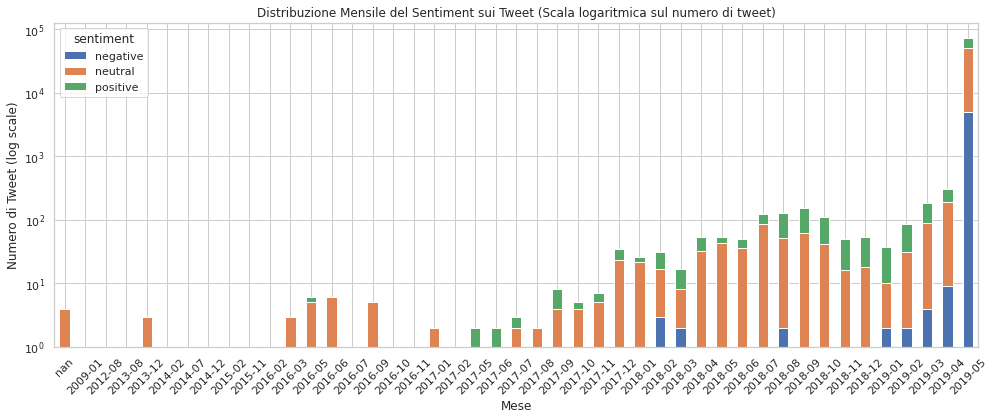

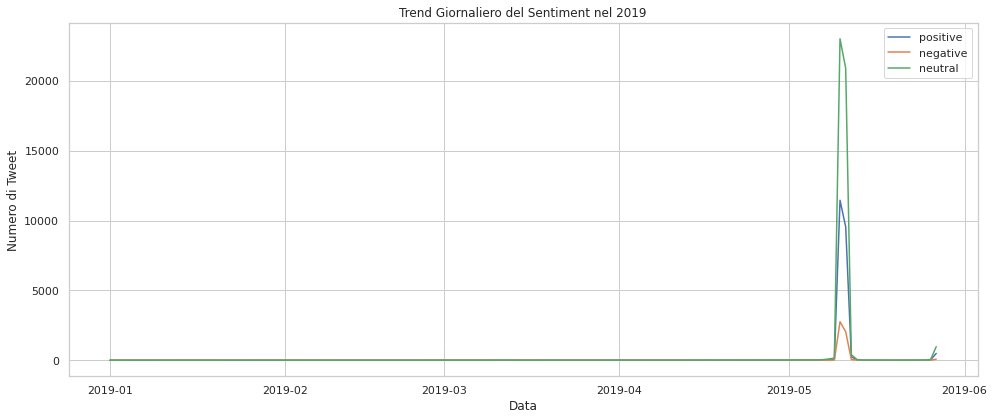

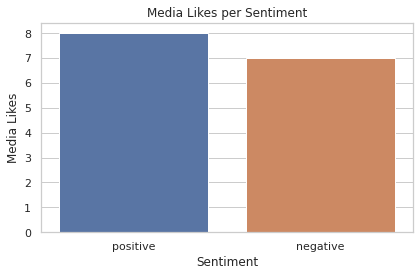

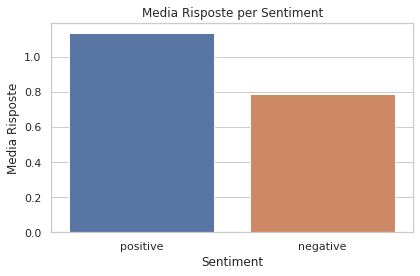

In [0]:
# COMMAND ----------

# Cell 8: Convertiamo il timestamp in una colonna di tipo data
# Questo passaggio è fondamentale per poter raggruppare i tweet in base al giorno o mese, per analisi temporali
df_sentiment = df_sentiment.withColumn("date", to_date(col("timestamp")))

# Mostriamo qualche esempio per confermare la conversione
df_sentiment.select("timestamp", "date").show(5, truncate=False)

# COMMENTO:
# Ora possiamo raggruppare i tweet per data e studiare come il sentiment varia nel tempo.

# COMMAND ----------

# Cell 9: Analisi e visualizzazione del sentiment aggregato mensilmente
# Raggruppiamo per mese e sentiment, contando il numero di tweet per ciascuna categoria

# Creiamo la colonna mese in formato "YYYY-MM"
df_monthly = df_sentiment.withColumn("month", date_format(col("date"), "yyyy-MM"))

# Raggruppiamo per mese e sentiment, conteggiando i tweet
monthly_sentiment = df_monthly.groupBy("month", "sentiment").count().toPandas()

# Pivot dei dati per ottenere colonne separate per sentiment
monthly_pivot = monthly_sentiment.pivot(index="month", columns="sentiment", values="count").fillna(0)

# Visualizziamo il grafico con barre impilate per mostrare la distribuzione mensile del sentiment
ax = monthly_pivot.plot(kind='bar', stacked=True, figsize=(14,6), logy=True)
plt.title("Distribuzione Mensile del Sentiment sui Tweet (Scala logaritmica sul numero di tweet)")
plt.xlabel("Mese")
plt.ylabel("Numero di Tweet (log scale)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# COMMENTO:
# La scala logaritmica permette di visualizzare meglio sia i mesi con pochi tweet sia quelli con molti.
# Il grafico mostra come il sentiment si distribuisce mensilmente tra positivo, negativo e neutro.
# Si possono notare picchi e variazioni interessanti nel tempo, utili per correlare eventi di mercato o notizie.

# COMMAND ----------

# Cell 10: Focus sull'anno 2019 — analisi dettagliata giornaliera del sentiment
# Il 2019 è l'anno con la maggior concentrazione di tweet, quindi vale la pena analizzarlo più nel dettaglio

df_2019 = df_sentiment.filter(year("date") == 2019)
df_2019_counts = df_2019.groupBy("date", "sentiment").count().toPandas()

# Pivot per struttura dati a colonne sentiment
pivot_2019 = df_2019_counts.pivot(index="date", columns="sentiment", values="count").fillna(0)

# Grafico lineare per visualizzare l'andamento giornaliero nel 2019
plt.figure(figsize=(14,6))
for sentiment in ["positive", "negative", "neutral"]:
    if sentiment in pivot_2019:
        plt.plot(pivot_2019.index, pivot_2019[sentiment], label=sentiment)
plt.title("Trend Giornaliero del Sentiment nel 2019")
plt.xlabel("Data")
plt.ylabel("Numero di Tweet")
plt.legend()
plt.tight_layout()
plt.show()

# COMMENTO:
# Il grafico mostra chiaramente l’andamento giornaliero del sentiment.
# È possibile osservare oscillazioni e picchi che potrebbero corrispondere a eventi di rilievo.
# Questo dettaglio temporale consente un’analisi più granulare rispetto alla vista mensile.

# COMMAND ----------

# Cell 11: Analisi dell'engagement — confronto tra Like medi per sentiment
# Analizziamo se i tweet con sentiment positivo o negativo ricevono più like medi

# Filtriamo i tweet con sentiment positivo o negativo
engagement_df = df_sentiment.filter((col("sentiment") == "positive") | (col("sentiment") == "negative"))

# Calcoliamo la media dei like per sentiment
likes_stats = engagement_df.groupBy("sentiment").agg(avg("likes").alias("avg_likes")).toPandas()

# Visualizziamo con un grafico a barre
plt.figure(figsize=(6,4))
sns.barplot(x="sentiment", y="avg_likes", data=likes_stats)
plt.title("Media Likes per Sentiment")
plt.ylabel("Media Likes")
plt.xlabel("Sentiment")
plt.tight_layout()
plt.show()

# COMMENTO:
# Questo grafico ci mostra se il pubblico tende a "premiare" con like i tweet positivi o negativi.
# Un maggiore engagement su tweet positivi potrebbe indicare un sentiment generale favorevole o ottimista.

# COMMAND ----------

# Cell 12: Analisi dell'engagement — confronto tra risposte medie per sentiment
# Simile all'analisi precedente, ma per il numero medio di risposte ricevute dai tweet

replies_stats = engagement_df.groupBy("sentiment").agg(avg("replies").alias("avg_replies")).toPandas()

plt.figure(figsize=(6,4))
sns.barplot(x="sentiment", y="avg_replies", data=replies_stats)
plt.title("Media Risposte per Sentiment")
plt.ylabel("Media Risposte")
plt.xlabel("Sentiment")
plt.tight_layout()
plt.show()

# COMMENTO:
# Il numero di risposte può indicare un maggior coinvolgimento o dibattito suscitato dai tweet.
# Confrontando con i like, possiamo capire se i tweet negativi, ad esempio, generano più discussione rispetto a quelli positivi.